In [41]:
import pandas as pd
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV, LassoCV
import lightgbm as lgb
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn import ensemble
from yellowbrick.regressor import ResidualsPlot
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.stats.mstats import winsorize
import warnings
warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.


In [2]:
data = pd.read_csv('Train.csv')

In [3]:
#function for dropping columns
def drop_col(df,col_list):
    for col in col_list:
        if col in df.columns:
            df.drop(col, axis = 1, inplace=True)
    return df

def plot_scatter(dataframe, target_col):
    plt.figure()
    for col in dataframe.columns:
        if col != target_col:
            plt.figure(figsize=(12,7))
            plt.scatter(x=dataframe[col], y=dataframe[target_col])
            plt.xlabel(col)
            plt.ylabel(target_col)
            
#outlier analysis
def plot_boxplots(dataframe):
    for col in dataframe.columns:
        plt.figure()
        dataframe.boxplot([col])
        
#checking the number of rows for each variable that fall outside 3*IQR range
def get_outliers_count(dataframe):
    count = {}
    for col in dataframe.columns:
        sorted_col = sorted(dataframe[col])
        Q1,Q3 = np.percentile(sorted_col , [25,75])
        IQR = Q3 - Q1
        lower_range = Q1 - (3 * IQR)
        upper_range = Q3 + (3 * IQR)    
        outliers_df = dataframe[(dataframe[col] > upper_range) | (dataframe[col] < lower_range)]
        count[col] = outliers_df[col].count()
    return count

#removes outliers which are not in 3*IQR range
def remove_outliers(dataframe, column):
    sorted_col = sorted(dataframe[column])
    Q1,Q3 = np.percentile(sorted_col , [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (3 * IQR)
    upper_range = Q3 + (3 * IQR)  
    print(lower_range)
    print(upper_range)
    dataframe_out = dataframe[(dataframe[column] > lower_range) & (dataframe[column] < upper_range)]
    return dataframe_out

def rmsle(actual_column, predicted_column):
    sum=0.0
    for x,y in zip(actual_column,predicted_column):
        if x<0 or y<0: #check for negative values. 
            continue
        p = np.log(y+1)
        r = np.log(x+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted_column))**0.5

def treat_outliers(dataframe, col_list):
    for col in col_list:
        dataframe[col] = winsorize(dataframe[col], limits=[0.05, 0.05],inclusive=(True, True))
    return dataframe

#for other variables using standard scaler
def scale(dataframe, cols_list):
    scaler = StandardScaler()
    dataframe[cols_list] = scaler.fit_transform(dataframe[cols_list])
    return dataframe,scaler

In [4]:
not_req = ['ID','region_code','personal_loan_active','vehicle_loan_active','personal_loan_closed','vehicle_loan_closed','loan_enq']

numerical_cols = ['age', 'cc_cons_apr', 'dc_cons_apr', 'cc_cons_may', 'dc_cons_may',
       'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr', 'cc_count_may',
       'cc_count_jun', 'dc_count_apr', 'dc_count_may', 'dc_count_jun',
       'card_lim', 'investment_1', 'investment_2', 'investment_3',
       'investment_4', 'debit_amount_apr', 'credit_amount_apr',
       'debit_count_apr', 'credit_count_apr', 'max_credit_amount_apr',
       'debit_amount_may', 'credit_amount_may', 'credit_count_may',
       'debit_count_may', 'max_credit_amount_may', 'debit_amount_jun',
       'credit_amount_jun', 'credit_count_jun', 'debit_count_jun',
       'max_credit_amount_jun', 'emi_active']

def custom_pipeline(dataframe, scaler):
    #dropping unnecessary columns
    not_req = ['ID','region_code','personal_loan_active','vehicle_loan_active','personal_loan_closed','vehicle_loan_closed','loan_enq']
    dataframe = dataframe.drop(not_req, axis=1)
    
    #one hot encoding on categorical data
    dataframe = pd.get_dummies(data=dataframe, columns=['account_type', 'gender'])
    
    #list of numerical and categorical columns
    numerical_cols = ['age', 'cc_cons_apr', 'dc_cons_apr', 'cc_cons_may', 'dc_cons_may',
       'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr', 'cc_count_may',
       'cc_count_jun', 'dc_count_apr', 'dc_count_may', 'dc_count_jun',
       'card_lim', 'investment_1', 'investment_2', 'investment_3',
       'investment_4', 'debit_amount_apr', 'credit_amount_apr',
       'debit_count_apr', 'credit_count_apr', 'max_credit_amount_apr',
       'debit_amount_may', 'credit_amount_may', 'credit_count_may',
       'debit_count_may', 'max_credit_amount_may', 'debit_amount_jun',
       'credit_amount_jun', 'credit_count_jun', 'debit_count_jun',
       'max_credit_amount_jun', 'emi_active']
    cat_cols = ['account_type_current','account_type_saving','gender_F','gender_M']
    
    #scaling on test data using same scaler used to fit on train data
    dataframe['investment_4'] = dataframe['investment_4'] - dataframe['investment_4'].min()
    dataframe[numerical_cols] = np.log1p(dataframe[numerical_cols])
    dataframe[numerical_cols] = scaler.transform(dataframe[numerical_cols])
    return dataframe

In [5]:
#removing unwanted columns 
data = drop_col(data, not_req)

In [6]:
#encoding categorical data using one hot encoding
data = pd.get_dummies(data=data, columns=['account_type', 'gender'])
data.head(5)

,age,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,...,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,cc_cons,account_type_current,account_type_saving,gender_F,gender_M
0,35,24893.00,378.00,10288.00,29664.00,16291.40,11432.00,2.0,26.0,10.0,...,12761.0,2.0,65.0,50836.0,1674.09,20014.0,1,0,0,1
1,35,18941.62,966.00,20672.00,287.00,4217.00,885.00,1.0,7.0,13.0,...,76206.0,21.0,63.0,23226.0,13043.34,10173.0,1,0,0,1
2,55,5678.87,2724.00,1964.50,3933.11,23956.25,5168.00,43.0,32.0,102.0,...,75283.0,7.0,1.0,27036.0,25375.27,16095.0,1,0,0,1
3,29,30489.50,1236.00,12609.88,9138.14,17521.00,13650.30,53.0,1.0,50.0,...,68708.0,21.0,83.0,43037.0,3544.33,7707.0,1,0,1,0
4,34,7441.40,6906.04,4364.00,1939.00,2121.00,6829.18,67.0,47.0,82.0,...,80140.0,8.0,32.0,32044.0,12780.44,96408.0,1,0,0,1


In [7]:
data = remove_outliers(data, 'age')

-27.0
113.0


In [8]:
cat_cols = ['account_type_current','account_type_saving','gender_F','gender_M']

In [9]:
X = data.drop(['cc_cons'], axis=1) 
y = np.log1p(data['cc_cons'])

In [10]:
treated_df = treat_outliers(X, numerical_cols)

In [11]:
treated_df['investment_4'].describe()

count    14466.000000
mean      3382.788398
std       6646.328325
min      -6281.379880
25%          0.000000
50%       2351.000000
75%       6885.000000
max      19765.000000
Name: investment_4, dtype: float64

In [12]:
treated_df['investment_4'] = treated_df['investment_4']-treated_df['investment_4'].min()

In [13]:
count_dict = get_outliers_count(treated_df)
outliers_count_df = pd.DataFrame(count_dict.items(), columns=['Column', 'Outliers count'])
outliers_count_df

,Column,Outliers count
0,age,0
1,cc_cons_apr,0
2,dc_cons_apr,0
3,cc_cons_may,0
4,dc_cons_may,0
5,cc_cons_jun,0
6,dc_cons_jun,0
7,cc_count_apr,0
8,cc_count_may,0
9,cc_count_jun,0


In [14]:
treated_df['investment_4'].describe()

count    14466.000000
mean      9664.168278
std       6646.328325
min          0.000000
25%       6281.379880
50%       8632.379880
75%      13166.379880
max      26046.379880
Name: investment_4, dtype: float64

In [15]:
#taking log transformation to remove skewness
treated_df[numerical_cols] = np.log1p(treated_df[numerical_cols])

In [16]:
treated_df.head()

,age,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,...,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,account_type_current,account_type_saving,gender_F,gender_M
0,3.583519,10.122382,5.937536,9.238831,10.140061,9.698454,9.344259,1.098612,3.295837,2.397895,...,10.310695,9.454227,1.098612,4.189655,10.836380,7.423622,1,0,0,1
1,3.583519,9.849170,6.874198,9.936584,6.021023,8.347116,6.786717,0.693147,2.079442,2.639057,...,10.648279,11.241209,3.091042,4.158883,10.053071,9.476110,1,0,0,1
2,4.025352,8.644684,7.910224,7.583502,8.277440,10.084026,8.550435,3.784190,3.496508,4.499810,...,10.974630,11.229023,2.079442,1.098612,10.204962,10.141570,1,0,0,1
3,3.401197,10.325170,7.120444,9.442315,9.120322,9.771213,9.521590,3.988984,1.098612,3.931826,...,11.154141,11.137635,3.091042,4.430817,10.669839,8.173387,1,0,1,0
4,3.555348,8.914949,8.840296,8.381373,7.570443,7.660114,8.829106,4.219508,3.871201,4.418841,...,9.217515,11.291543,2.197225,3.496508,10.374896,9.455749,1,0,0,1


In [17]:
scaled_df,scaler_train = scale(treated_df, numerical_cols)

In [18]:
scaled_df.head()

,age,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,...,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,account_type_current,account_type_saving,gender_F,gender_M
0,-0.586902,0.888070,-1.931765,0.201300,1.744251,0.881015,1.109502,-1.284291,0.312270,-0.823730,...,-0.457267,-1.225722,-1.240968,0.769080,0.561216,-0.543990,1,0,0,1
1,-0.586902,0.634547,-1.141428,0.833577,-1.938562,-0.394453,-1.110004,-1.621116,-0.837616,-0.592003,...,-0.078522,0.561095,0.647749,0.738948,-0.225758,0.955794,1,0,0,1
2,1.061366,-0.483134,-0.267251,-1.298695,0.078890,1.244939,0.420599,0.946658,0.501969,1.195950,...,0.287620,0.548911,-0.311195,-2.257727,-0.073156,1.442056,1,0,0,1
3,-1.267058,1.076243,-0.933651,0.385690,0.832507,0.949688,1.263395,1.116783,-1.764816,0.650188,...,0.489018,0.457532,0.647749,1.005230,0.393896,0.003874,1,0,1,0
4,-0.691994,-0.232346,0.517526,-0.575695,-0.553233,-1.042884,0.662438,1.308283,0.856175,1.118149,...,-1.683736,0.611425,-0.199543,0.090337,0.097574,0.940916,1,0,0,1


In [21]:
#assessing linear model on this data
X_train, X_test, y_train, y_test = train_test_split(scaled_df, y, test_size=0.33, random_state=12)
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)
print("Training score: "+str(linear_model.score(X_train, y_train)))
print("Test score: "+str(linear_model.score(X_test, y_test)))

Training score: 0.004480920634956087
Test score: -0.004908111894700307


In [106]:
y_pred

array([9.74316406, 9.66601562, 9.66113281, ..., 9.61523438, 9.49902344,
       9.67382812])

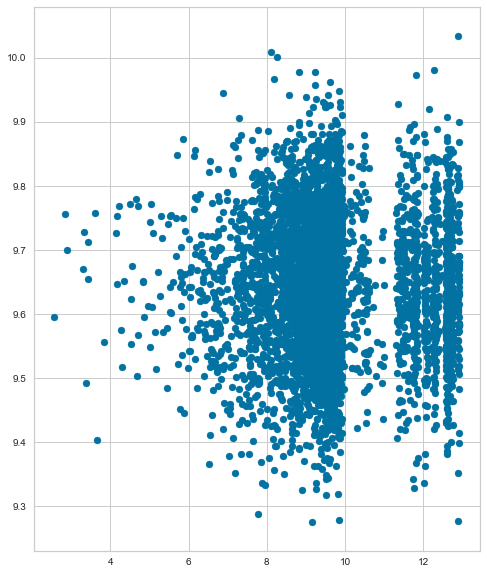

In [107]:
plt.scatter(x=y_test, y=y_pred)

In [108]:
print(metrics.mean_absolute_error(y_test, y_pred))
print(metrics.mean_squared_error(y_test, y_pred))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

1.1691205797616706
2.641559557339181
1.6252875306662453


In [109]:
print(rmsle(y_test, y_pred))

0.15887456448282272


(array([   9.,   15.,   36.,  129.,  327.,  925., 2211.,  140.,  418.,
         564.]),
 array([-7.03075377, -5.96695673, -4.90315968, -3.83936264, -2.7755656 ,
        -1.71176856, -0.64797152,  0.41582552,  1.47962257,  2.54341961,
         3.60721665]),
 <a list of 10 Patch objects>)

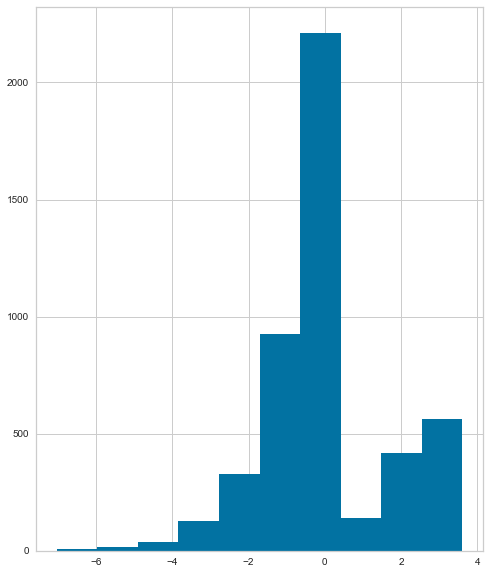

In [110]:
resid = y_test - y_pred
plt.hist(resid)

In [111]:
dt_model = DecisionTreeRegressor(random_state=0)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print("Training score: "+str(dt_model.score(X_train, y_train)))
print("Test score: "+str(dt_model.score(X_test, y_test)))

Training score: 0.9999999999449624
Test score: -1.156925119934852


In [112]:
print(metrics.mean_absolute_error(y_test, y_pred_dt))
print(metrics.mean_squared_error(y_test, y_pred_dt))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred_dt)))

1.8365474187644024
5.66981806355037
2.3811379765881626


In [113]:
print(rmsle(y_test, y_pred_dt))

0.23133829777480214


(array([9.000e+00, 6.200e+01, 3.200e+02, 8.230e+02, 1.565e+03, 1.137e+03,
        6.680e+02, 1.620e+02, 2.700e+01, 1.000e+00]),
 array([-9.01913865, -7.15151679, -5.28389493, -3.41627307, -1.54865121,
         0.31897065,  2.18659251,  4.05421436,  5.92183622,  7.78945808,
         9.65707994]),
 <a list of 10 Patch objects>)

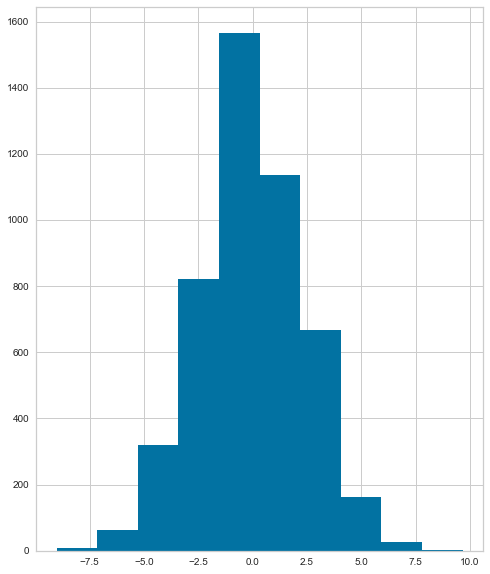

In [114]:
resid = y_test - y_pred_dt
plt.hist(resid)

In [115]:
rf_model = RandomForestRegressor(random_state=0)
rf_model.fit(scaled_df, y)
y_pred_rf = rf_model.predict(X_test)
print("Training score: "+str(rf_model.score(X_train, y_train)))
print("Test score: "+str(rf_model.score(X_test, y_test)))

Training score: 0.7976963678590347
Test score: 0.7921387377464251


In [116]:
print(metrics.mean_absolute_error(y_test, y_pred_rf))
print(metrics.mean_squared_error(y_test, y_pred_rf))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf)))

0.5352887155661515
0.5463961305589023
0.7391861271418061


In [117]:
print(rmsle(np.expm1(y_test), np.expm1(y_pred_rf)))

0.7391861271418059


(array([   6.,    4.,   19.,  106.,  522., 2166., 1355.,  445.,  134.,
          17.]),
 array([-4.38114447, -3.64103807, -2.90093166, -2.16082525, -1.42071885,
        -0.68061244,  0.05949397,  0.79960037,  1.53970678,  2.27981319,
         3.01991959]),
 <a list of 10 Patch objects>)

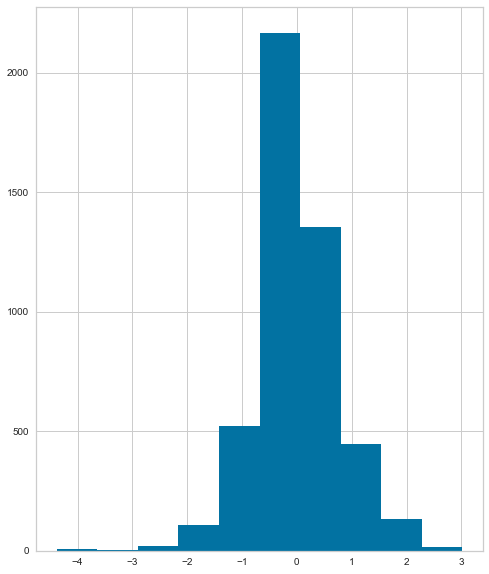

In [118]:
resid = y_test - y_pred_rf
plt.hist(resid)

In [119]:
test_data = pd.read_csv('Test.csv')

In [120]:
test_scaled = custom_pipeline(test_data, scaler_train)

In [121]:
test_scaled.head()

,age,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,...,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,account_type_current,account_type_saving,gender_F,gender_M
0,-0.385203,-1.140645,-0.897598,-0.266204,-1.493851,0.336163,1.372493,-0.859940,-0.536575,-1.581341,...,-0.439615,-0.329553,-0.968261,-0.821862,-0.114502,-0.805287,1,0,0,1
1,-0.800133,1.042641,-0.695185,-1.445788,-0.339122,0.505836,-1.043106,-1.045309,-0.536575,-1.581341,...,-1.287067,-0.963840,-0.437775,0.278711,-0.871415,1.125230,1,0,0,1
2,0.925696,-0.434391,0.425042,-1.011962,-1.382914,-2.067004,0.226743,-0.469501,0.442867,-1.406152,...,-0.369276,-0.259528,-0.583902,-1.078774,-0.792283,-0.216222,1,0,0,1
3,-0.800133,-1.403360,1.336252,1.304573,-2.740619,-0.384820,1.602849,-1.621116,1.550013,0.981537,...,0.817025,0.922901,0.647749,-3.333509,0.915314,-1.705408,1,0,0,1
4,1.500759,-0.995480,-0.048139,-0.868599,-0.257422,-0.605046,0.412503,-1.284291,-0.536575,0.591935,...,-0.970934,-0.048973,-0.437775,0.175540,0.377587,-0.165147,1,0,0,1


In [122]:
y_pred_rf = rf_model.predict(test_scaled)

In [123]:
np.expm1(y_pred_rf)

array([13149.08488401,  7428.2937936 , 24986.11235951, ...,
       11025.69895058,  9711.10841681, 34126.48099037])

In [124]:
to_submit = pd.DataFrame({'ID': test_data['ID'], 'cc_cons': np.expm1(y_pred_rf)} )

In [125]:
to_submit.to_csv('full_data_train.csv', index=False)

In [126]:
to_submit.head()

,ID,cc_cons
0,17591,13149.084884
1,13541,7428.293794
2,13431,24986.112360
3,8687,23094.751334
4,14727,14515.303542


### We are getting RMSLE score of 0.7 on train and 1.7 on test. There is a possibility of overfitting. Applying L1 (Lasso) regularisation to check if it improves test RMSLE

In [148]:
lasso_m_ = Lasso()
alpha  = [0.001,0.005,0.01,0.3,0.1,0.3,0.5,0.7,1]
lasso_params_ = { 'max_iter':[500],'alpha':alpha}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_lasso_m = GridSearchCV( lasso_m_, lasso_params_, scoring=rmsle_scorer, cv=5) #cv is the number of folds for cross validations

In [149]:
grid_lasso_m.fit(X = X_train,y =y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.001, 0.005, 0.01, 0.3, 0.1, 0.3, 0.5, 0.7,
                                   1],
                         'max_iter': [500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(rmsle, greater_is_better=False), verbose=0)

In [150]:
pred_lasso = grid_lasso_m.predict(X= X_test)

In [151]:
np.expm1(pred_lasso)

array([15442.85862846, 15442.85862846, 15442.85862846, ...,
       15442.85862846, 15442.85862846, 15442.85862846])

In [152]:
#getting the optimum value of alpha and iterations
print (grid_lasso_m.best_params_)

{'alpha': 0.3, 'max_iter': 500}


In [153]:
print(rmsle(np.expm1(y_test), np.expm1(pred_lasso)))

1.6213138121885475


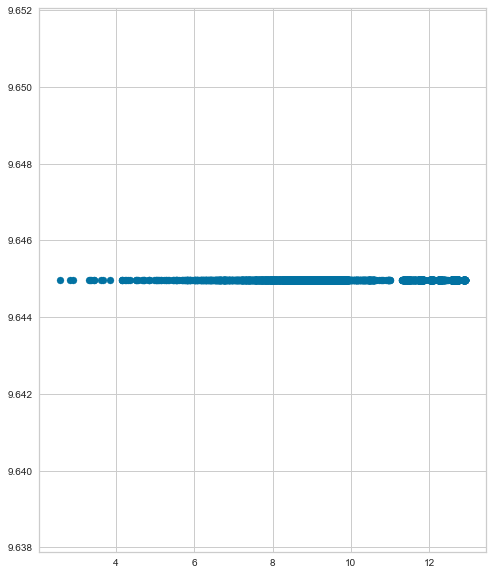

In [133]:
plt.scatter(x=y_test, y=pred_lasso)

In [134]:
test_data = pd.read_csv('Test.csv')
test_scaled = custom_pipeline(test_data, scaler_train)
test_scaled.head()

,age,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,...,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,account_type_current,account_type_saving,gender_F,gender_M
0,-0.385203,-1.140645,-0.897598,-0.266204,-1.493851,0.336163,1.372493,-0.859940,-0.536575,-1.581341,...,-0.439615,-0.329553,-0.968261,-0.821862,-0.114502,-0.805287,1,0,0,1
1,-0.800133,1.042641,-0.695185,-1.445788,-0.339122,0.505836,-1.043106,-1.045309,-0.536575,-1.581341,...,-1.287067,-0.963840,-0.437775,0.278711,-0.871415,1.125230,1,0,0,1
2,0.925696,-0.434391,0.425042,-1.011962,-1.382914,-2.067004,0.226743,-0.469501,0.442867,-1.406152,...,-0.369276,-0.259528,-0.583902,-1.078774,-0.792283,-0.216222,1,0,0,1
3,-0.800133,-1.403360,1.336252,1.304573,-2.740619,-0.384820,1.602849,-1.621116,1.550013,0.981537,...,0.817025,0.922901,0.647749,-3.333509,0.915314,-1.705408,1,0,0,1
4,1.500759,-0.995480,-0.048139,-0.868599,-0.257422,-0.605046,0.412503,-1.284291,-0.536575,0.591935,...,-0.970934,-0.048973,-0.437775,0.175540,0.377587,-0.165147,1,0,0,1


In [135]:
pred_l1_test = grid_lasso_m.predict(test_scaled)
pred_l1_test

array([9.6449667, 9.6449667, 9.6449667, ..., 9.6449667, 9.6449667,
       9.6449667])

In [136]:
to_submit = pd.DataFrame({'ID': test_data['ID'], 'cc_cons': np.expm1(pred_l1_test)} )
to_submit.to_csv('lasso_pred.csv', index=False)
to_submit.head()

,ID,cc_cons
0,17591,15442.858628
1,13541,15442.858628
2,13431,15442.858628
3,8687,15442.858628
4,14727,15442.858628


### After applying Lasso the train and test RMSLE score are same...hence the problem of overfitting is removed

In [137]:
reg = LassoCV()
reg.fit(X_train, y_train)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 0.050728
Best score using built-in LassoCV: 0.000117


In [138]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 1 variables and eliminated the other 37 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

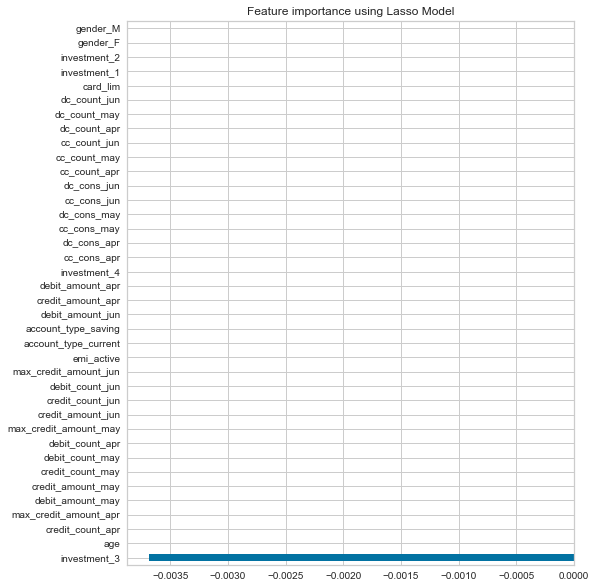

In [139]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

### Lasso almost removes all variables..this might be due to multi-collinearity amongst the variables

In [144]:
rf_model = RandomForestRegressor()
rfe = RFE(rf_model, 7)

In [145]:
X_rfe = rfe.fit_transform(X,y)

In [146]:
rf_model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)

[False  True  True False False False  True False False False False False
 False False False False False False False False False False  True False
 False False False  True False  True False False  True False False False
 False False]
[23  1  1  2 11  4  1 22 20 19 24 25 21 13  7  9 15 14 10  3 18 27  1 12
  6 28 16  1  5  1 26 17  1  8 31 30 29 32]


In [147]:
X.shape

(14466, 38)

In [59]:
#no of features
nof_list=np.arange(27,29)   #we currently had 38 features          
lowest_rmsle_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = RandomForestRegressor()
    rfe = RFE(model,nof_list[n])
    print(nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    rfe_pred = model.predict(X_test_rfe)
    print(rfe_pred)
    rmsle_score = rmsle(np.expm1(y_test), np.expm1(rfe_pred))
    print(rmsle_score)
    if(rmsle_score < lowest_rmsle_score):
        lowest_rmsle_score = rmsle_score
        nof = nof_list[n]

27
[ 9.52980154 10.57875828 10.37270967 ...  9.17988928 10.51704671
  9.60016513]
1.7049779866341208
28
[ 9.48076024  9.62354336 10.74332571 ...  9.80432031  9.19360741
  9.09373121]
1.6998404440644597


### RFE gave optimum number of features as 28. Fitting the RFE model on this number of features

In [60]:
cols = list(X.columns)
model = RandomForestRegressor()#Initializing RFE model
rfe = RFE(model, 28)             #Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  #Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['cc_cons_apr', 'dc_cons_apr', 'cc_cons_may', 'dc_cons_may',
       'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr', 'cc_count_may',
       'cc_count_jun', 'dc_count_jun', 'card_lim', 'investment_1',
       'investment_2', 'investment_3', 'investment_4', 'debit_amount_apr',
       'credit_amount_apr', 'debit_count_apr', 'max_credit_amount_apr',
       'debit_amount_may', 'credit_amount_may', 'debit_count_may',
       'max_credit_amount_may', 'debit_amount_jun', 'credit_amount_jun',
       'debit_count_jun', 'max_credit_amount_jun', 'emi_active'],
      dtype='object')


In [61]:
selected_feat = ['age', 'cc_cons_apr', 'dc_cons_apr', 'cc_cons_may', 'dc_cons_may',
       'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr', 'cc_count_may',
       'cc_count_jun', 'card_lim', 'investment_1', 'investment_2',
       'investment_3', 'investment_4', 'debit_amount_apr', 'credit_amount_apr',
       'debit_count_apr', 'max_credit_amount_apr', 'debit_amount_may',
       'credit_amount_may', 'debit_count_may', 'max_credit_amount_may',
       'debit_amount_jun', 'credit_amount_jun', 'debit_count_jun',
       'max_credit_amount_jun', 'emi_active']


In [62]:
X_sel = X[selected_feat]

In [63]:
#assessing linear model on this data
X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.33, random_state=12)
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)
print("Training score: "+str(linear_model.score(X_train, y_train)))
print("Test score: "+str(linear_model.score(X_test, y_test)))

Training score: 0.0034245355608860657
Test score: -0.002800496762705995


In [64]:
print(metrics.mean_absolute_error(y_test, y_pred))
print(metrics.mean_squared_error(y_test, y_pred))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

1.1627282574628253
2.6161636920898674
1.6174559320395308


In [65]:
print(rmsle(np.expm1(y_test), np.expm1(y_pred)))

1.6174559320395316


In [66]:
test_scaled = test_scaled[selected_feat]
test_scaled.head()

,age,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,...,max_credit_amount_apr,debit_amount_may,credit_amount_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,debit_count_jun,max_credit_amount_jun,emi_active
0,-0.432509,-1.141164,-0.897372,-0.265498,-1.493053,0.337452,1.367558,-0.860677,-0.539222,-1.580945,...,-0.475478,-0.523079,-0.122537,-0.224610,-1.478914,-0.435913,-0.329662,-0.822768,-0.117456,-0.807599
1,-0.834163,1.041463,-0.695069,-1.445321,-0.338759,0.506929,-1.041570,-1.045959,-0.539222,-1.580945,...,-3.332659,-1.003076,1.060511,0.472196,-0.803141,-1.284128,-0.966051,0.277558,-0.877837,1.125516
2,0.836445,-0.435123,0.424547,-1.011407,-1.382158,-2.062939,0.224878,-0.470419,0.441097,-1.405771,...,-1.186847,1.346367,-0.156265,0.336748,0.127898,-0.365511,-0.259404,-1.079622,-0.798343,-0.217741
3,-0.834163,-1.403799,1.335261,1.305597,-2.739351,-0.382698,1.597297,-1.621500,1.549234,0.981723,...,2.790743,1.030872,0.025560,-1.529347,1.333946,0.821859,0.926944,-3.333848,0.917079,-1.708932
4,1.393108,-0.996043,-0.048376,-0.868015,-0.257089,-0.602670,0.410139,-1.284830,-0.539222,0.592153,...,-1.231413,1.726877,-0.617961,1.114962,-0.194873,-0.967710,-0.048151,0.174410,0.376888,-0.166597


In [67]:
lin_pred = linear_model.predict(test_scaled)
to_submit = pd.DataFrame({'ID': test_data['ID'], 'cc_cons': np.expm1(lin_pred)} )
to_submit.to_csv('lin_sel.csv', index=False)
to_submit.head()

,ID,cc_cons
0,17591,15577.003991
1,13541,16275.399769
2,13431,13756.807805
3,8687,15648.201628
4,14727,14275.001738


In [68]:
dt_model = DecisionTreeRegressor(random_state=0)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print("Training score: "+str(dt_model.score(X_train, y_train)))
print("Test score: "+str(dt_model.score(X_test, y_test)))
print(metrics.mean_absolute_error(y_test, y_pred_dt))
print(metrics.mean_squared_error(y_test, y_pred_dt))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred_dt)))
print(rmsle(np.expm1(y_test), np.expm1(y_pred_dt)))

Training score: 0.9999999998929083
Test score: -1.1934627879308426
1.8275018834822498
5.72243205329483
2.3921605408698703
2.392160540869871


In [69]:
dt_pred = dt_model.predict(test_scaled)
to_submit = pd.DataFrame({'ID': test_data['ID'], 'cc_cons': np.expm1(dt_pred)} )
to_submit.to_csv('dt_sel.csv', index=False)
to_submit.head()

,ID,cc_cons
0,17591,2579.0
1,13541,328052.0
2,13431,2870.0
3,8687,16879.0
4,14727,4241.0


In [70]:
rf_model = RandomForestRegressor(random_state=0)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Training score: "+str(rf_model.score(X_train, y_train)))
print("Test score: "+str(rf_model.score(X_test, y_test)))
print(metrics.mean_absolute_error(y_test, y_pred_rf))
print(metrics.mean_squared_error(y_test, y_pred_rf))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf)))
print(rmsle(np.expm1(y_test), np.expm1(y_pred_rf)))

Training score: 0.7998708056014665
Test score: -0.1200909488258466
1.293384306844676
2.922157778757144
1.709432004718861
1.7094320047188623


In [71]:
rf_pred = rf_model.predict(test_scaled)
to_submit = pd.DataFrame({'ID': test_data['ID'], 'cc_cons': np.expm1(rf_pred)} )
to_submit.to_csv('rf_sel.csv', index=False)
to_submit.head()

,ID,cc_cons
0,17591,8886.520514
1,13541,8888.127766
2,13431,17293.304996
3,8687,13387.281530
4,14727,6362.621858


In [72]:
grid_lasso_m.fit(X = X_train,y =y_train)
lasso_pred = grid_lasso_m.predict(X_test)
print(rmsle(np.expm1(y_test), np.expm1(lasso_pred)))

1.6162431741903436


In [73]:
l1_pred = grid_lasso_m.predict(test_scaled)
to_submit = pd.DataFrame({'ID': test_data['ID'], 'cc_cons': np.expm1(l1_pred)} )
to_submit.to_csv('lasso_sel.csv', index=False)
to_submit.head()

,ID,cc_cons
0,17591,15767.445396
1,13541,16705.317858
2,13431,14893.980453
3,8687,15450.734024
4,14727,14710.429098


### Till now we are getting RMSLE of 1.61. Applying boosting for improvement

In [78]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
gb_model = ensemble.GradientBoostingRegressor(**params)

gb_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [79]:
gb_pred = gb_model.predict(X_test)

In [81]:
print(rmsle(np.expm1(y_test), np.expm1(gb_pred)))

1.6246646981978385


In [34]:
model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=90,
                      max_features=2, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=12,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [35]:
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=90,
                      max_features=2, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=12,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [36]:
pred = model.predict(X_test)

In [37]:
print(rmsle(np.expm1(y_test), np.expm1(pred)))

1.6264676183479878


Feature ranking:
1. credit_amount_jun (0.033035)
2. cc_cons_may (0.032826)
3. debit_amount_may (0.032551)
4. max_credit_amount_jun (0.032197)
5. debit_amount_jun (0.032148)
6. dc_cons_apr (0.032090)
7. dc_cons_jun (0.032030)
8. cc_cons_jun (0.032028)
9. max_credit_amount_may (0.032016)
10. emi_active (0.031959)
11. investment_2 (0.031786)
12. max_credit_amount_apr (0.031781)
13. cc_cons_apr (0.031577)
14. credit_amount_apr (0.031508)
15. dc_cons_may (0.031357)
16. investment_1 (0.031117)
17. investment_3 (0.031094)
18. credit_amount_may (0.031046)
19. debit_amount_apr (0.030554)
20. card_lim (0.029943)
21. investment_4 (0.028971)
22. debit_count_jun (0.026988)
23. debit_count_apr (0.026967)
24. debit_count_may (0.026740)
25. cc_count_may (0.026340)
26. cc_count_jun (0.026122)
27. dc_count_jun (0.026020)
28. cc_count_apr (0.025593)
29. age (0.025224)
30. dc_count_apr (0.024497)
31. credit_count_jun (0.023661)
32. dc_count_may (0.023089)
33. credit_count_may (0.022445)
34. credit_count_a

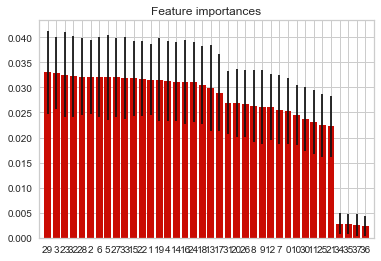

In [52]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [44]:
X.columns

Index(['age', 'cc_cons_apr', 'dc_cons_apr', 'cc_cons_may', 'dc_cons_may',
       'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr', 'cc_count_may',
       'cc_count_jun', 'dc_count_apr', 'dc_count_may', 'dc_count_jun',
       'card_lim', 'investment_1', 'investment_2', 'investment_3',
       'investment_4', 'debit_amount_apr', 'credit_amount_apr',
       'debit_count_apr', 'credit_count_apr', 'max_credit_amount_apr',
       'debit_amount_may', 'credit_amount_may', 'credit_count_may',
       'debit_count_may', 'max_credit_amount_may', 'debit_amount_jun',
       'credit_amount_jun', 'credit_count_jun', 'debit_count_jun',
       'max_credit_amount_jun', 'emi_active', 'account_type_current',
       'account_type_saving', 'gender_F', 'gender_M'],
      dtype='object')

In [55]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [56]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [57]:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

[1]	valid_0's l1: 1.16297	valid_0's l2: 2.62885
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 1.16276	valid_0's l2: 2.628
[3]	valid_0's l1: 1.1628	valid_0's l2: 2.62722
[4]	valid_0's l1: 1.16272	valid_0's l2: 2.62694
[5]	valid_0's l1: 1.16291	valid_0's l2: 2.62845
[6]	valid_0's l1: 1.16324	valid_0's l2: 2.62877
[7]	valid_0's l1: 1.16332	valid_0's l2: 2.62834
[8]	valid_0's l1: 1.16369	valid_0's l2: 2.62951
[9]	valid_0's l1: 1.16406	valid_0's l2: 2.62981
Early stopping, best iteration is:
[4]	valid_0's l1: 1.16272	valid_0's l2: 2.62694


In [58]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [60]:
print(rmsle(np.expm1(y_test), np.expm1(y_pred)))

1.6207829177415098


In [62]:
test_data = pd.read_csv('Test.csv')
test_scaled = custom_pipeline(test_data, scaler_train)
test_scaled.head()

,age,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,...,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,account_type_current,account_type_saving,gender_F,gender_M
0,-0.385203,-1.140645,-0.897598,-0.266204,-1.493851,0.336163,1.372493,-0.859940,-0.536575,-1.581341,...,-0.439615,-0.329553,-0.968261,-0.821862,-0.114502,-0.805287,1,0,0,1
1,-0.800133,1.042641,-0.695185,-1.445788,-0.339122,0.505836,-1.043106,-1.045309,-0.536575,-1.581341,...,-1.287067,-0.963840,-0.437775,0.278711,-0.871415,1.125230,1,0,0,1
2,0.925696,-0.434391,0.425042,-1.011962,-1.382914,-2.067004,0.226743,-0.469501,0.442867,-1.406152,...,-0.369276,-0.259528,-0.583902,-1.078774,-0.792283,-0.216222,1,0,0,1
3,-0.800133,-1.403360,1.336252,1.304573,-2.740619,-0.384820,1.602849,-1.621116,1.550013,0.981537,...,0.817025,0.922901,0.647749,-3.333509,0.915314,-1.705408,1,0,0,1
4,1.500759,-0.995480,-0.048139,-0.868599,-0.257422,-0.605046,0.412503,-1.284291,-0.536575,0.591935,...,-0.970934,-0.048973,-0.437775,0.175540,0.377587,-0.165147,1,0,0,1


In [61]:
to_submit = pd.DataFrame({'ID': test_data['ID'], 'cc_cons': np.expm1(y_pred)} )
to_submit.to_csv('lgbm_pred.csv', index=False)
to_submit.head()

NameError: name 'test_data' is not defined